In [1]:
# 1. importing libraries, defining data paths + loading the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

metadata_path = "/Users/School/Downloads/Data/Electrolyte_metadata.csv"
saxs_folder = "/Users/School/Downloads/Data/SAXS_data"


In [2]:
#making sure that i have the correct filepath and files.
import os, glob
print("Looking in:", saxs_folder)
print("Files found:", os.listdir(saxs_folder))
print("E‑files:", glob.glob(os.path.join(saxs_folder, "E*")))


Looking in: /Users/School/Downloads/Data/SAXS_data
Files found: ['E32.dat', 'E26.dat', 'E109.dat', 'E108.dat', 'E27.dat', 'E33.dat', 'E19.dat', 'E25.dat', 'E31.dat', 'E30.dat', 'E24.dat', 'E18.dat', 'E20.dat', 'E34.dat', '.DS_Store', 'E35.dat', 'E21.dat', 'E37.dat', 'E23.dat', 'E22.dat', 'E36.dat', 'E79.dat', 'E51.dat', 'E45.dat', 'E92.dat', 'E86.dat', 'E87.dat', 'E93.dat', 'E44.dat', 'E50.dat', 'E78.dat', 'E46.dat', 'E52.dat', 'E85.dat', 'E91.dat', 'E90.dat', 'E84.dat', 'E53.dat', 'E47.dat', 'E43.dat', 'E57.dat', 'E80.dat', 'E94.dat', 'E95.dat', 'E81.dat', 'E56.dat', 'E42.dat', 'E54.dat', 'E40.dat', 'E68.dat', 'E97.dat', 'E83.dat', 'E9.dat', 'E8.dat', 'E82.dat', 'E96.dat', 'E69.dat', 'E41.dat', 'E55.dat', 'E58.dat', 'E70.dat', 'E5.dat', 'E4.dat', 'E65.dat', 'E71.dat', 'E59.dat', 'E67.dat', 'E73.dat', 'E98.dat', 'E6.dat', 'E7.dat', 'E99.dat', 'E72.dat', 'E66.dat', 'E62.dat', 'E76.dat', 'E89.dat', 'E3.dat', 'E2.dat', 'E88.dat', 'E77.dat', 'E63.dat', 'E75.dat', 'E61.dat', 'E49.dat', 'E1.

In [3]:
import os
import glob
import numpy as np
import pandas as pd
df = pd.read_csv('/Users/School/Downloads/Data/Electrolyte_metadata.csv')
saxs_folder = '/Users/School/Downloads/Data/SAXS_data'


# 2. Load electrolyte metadata, filter out immiscible samples (where avg density = NaN or 0)
df = pd.read_csv(metadata_path)

df = df[df["Average Density"].notna()]
df = df[df["Average Density"] != 0]

print(f"Total samples after filtering: {len(df)}")

X_list, y_list = [], []

for _, row in df.iterrows():
    count   = int(row["Count"])
    density = row["Average Density"]

    pattern = os.path.join(saxs_folder, f"E{count}*")
    files   = glob.glob(pattern)
    if not files:
        print(f"[skip] no SAXS file for sample E{count}")
        continue
    filename = files[0]

    # load and normalize
    data   = np.loadtxt(filename)
    q_vals = data[:, 0]
    I_vals = data[:, 1]

    area = np.trapezoid(I_vals, q_vals)
    if area <= 0:
        print(f"[skip] zero/negative area for E{count}")
        continue

    I_norm = I_vals / area
    X_list.append(I_norm)
    y_list.append(density)

X = np.array(X_list)
y = np.array(y_list)
print("Shape of feature matrix X:", X.shape)


Total samples after filtering: 100
[skip] no SAXS file for sample E74
Shape of feature matrix X: (99, 955)


In [4]:
# Apply PCA to reduce dimensionality of the spectra
n_components = 8  # number of principal components to keep (choose based on variance explained or trial)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

print("Original feature dimension:", X.shape[1])
print("Reduced feature dimension:", X_pca.shape[1])


Original feature dimension: 955
Reduced feature dimension: 8


In [5]:
# Split into training and testing sets. this is determined by the number of samples
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)
print("Training samples:", X_train.shape[0], "Testing samples:", X_test.shape[0])


Training samples: 79 Testing samples: 20


In [6]:
# Initialize models with settings to mitigate overfitting
lin_reg = LinearRegression()
ridge_reg = Ridge(alpha=1.0)             # L2 regularization with alpha=1.0
rf_reg = RandomForestRegressor(
    n_estimators=100, max_depth=5, random_state=42
)  # 100 trees, max_depth=5 to limit complexity

# Train each model
lin_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)

# Evaluate on training set
print("R^2 on Training set:")
print("Linear Regression:", r2_score(y_train, lin_reg.predict(X_train)))
print("Ridge Regression:", r2_score(y_train, ridge_reg.predict(X_train)))
print("Random Forest:", r2_score(y_train, rf_reg.predict(X_train)))

# Evaluate on test set
print("\nR^2 on Test set:")
print("Linear Regression:", r2_score(y_test, lin_reg.predict(X_test)))
print("Ridge Regression:", r2_score(y_test, ridge_reg.predict(X_test)))
print("Random Forest:", r2_score(y_test, rf_reg.predict(X_test)))


R^2 on Training set:
Linear Regression: 0.5634662711710998
Ridge Regression: 0.514922286915594
Random Forest: 0.8725132773356401

R^2 on Test set:
Linear Regression: 0.6715944345054636
Ridge Regression: 0.7010665203204227
Random Forest: 0.6602741017786182


Best model: Ridge Regression with R^2 train=0.515, test=0.701


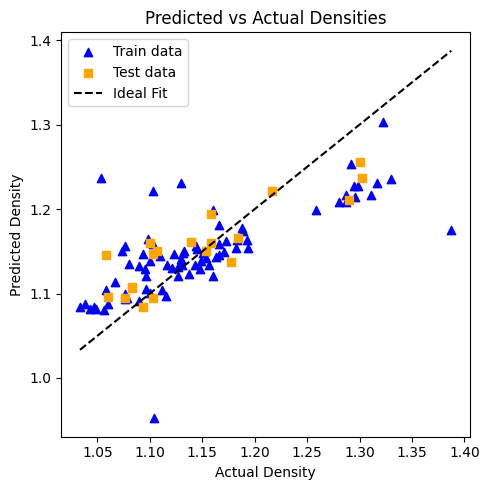

In [7]:
# Choose the best model (for example, ridge_reg)
best_model = ridge_reg

# Predict on both training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Compute R^2 for confirmation
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Best model: Ridge Regression with R^2 train={train_r2:.3f}, test={test_r2:.3f}")

# Plot actual vs predicted densities
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, marker= '^', color='blue', label='Train data')
plt.scatter(y_test, y_test_pred, marker= 's', color='orange', label='Test data')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', label='Ideal Fit')  # 45-degree line
plt.xlabel("Actual Density")
plt.ylabel("Predicted Density")
plt.legend()
plt.title("Predicted vs Actual Densities")
plt.tight_layout()
plt.savefig("pred_vs_actual.png")


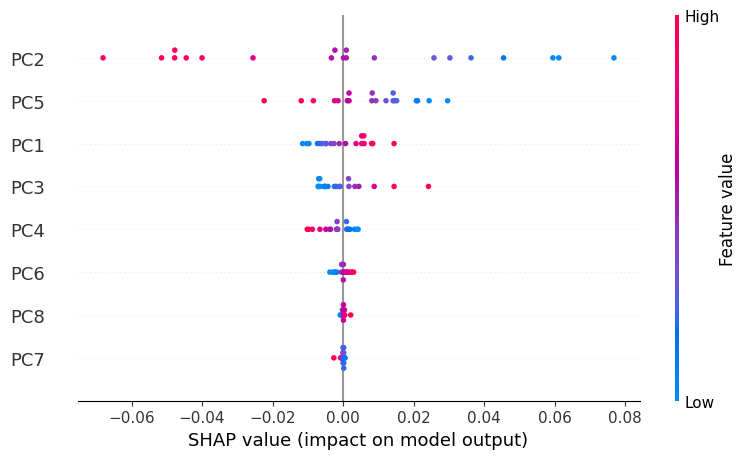

In [8]:
import shap

# Initialize SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_train)  # for linear models, Explainer uses a suitable method under the hood
shap_values = explainer(X_test)  # compute SHAP values for the test set

# Plot a summary of feature importances
shap.summary_plot(shap_values.values, X_test, feature_names=[f"PC{i+1}" for i in range(X_test.shape[1])])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple autoencoder architecture
class SAXSAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SAXSAutoencoder, self).__init__()
        # Encoder: compress input to latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder: reconstruct from latent_dim back to original dimension
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Initialize autoencoder
input_dim = X.shape[1]        # original spectrum length (e.g., ~950)
latent_dim = 8                # compress to 8 dimensions, similar to PCA
autoencoder = SAXSAutoencoder(input_dim, latent_dim)

# Training setup
criterion = nn.MSELoss()      # reconstruction error (mean squared error)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Train the autoencoder
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    recon = autoencoder(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Reconstruction Loss: {loss.item():.4f}")


Epoch 0, Reconstruction Loss: 0.1238
Epoch 10, Reconstruction Loss: 0.0760
Epoch 20, Reconstruction Loss: 0.0294
Epoch 30, Reconstruction Loss: 0.0090
Epoch 40, Reconstruction Loss: 0.0044
Epoch 50, Reconstruction Loss: 0.0030
Epoch 60, Reconstruction Loss: 0.0026
Epoch 70, Reconstruction Loss: 0.0025
Epoch 80, Reconstruction Loss: 0.0024
Epoch 90, Reconstruction Loss: 0.0024


In [10]:
# Get latent features for each sample
with torch.no_grad():
    latent_features = autoencoder.encoder(X_tensor).numpy()
print("Latent feature matrix shape:", latent_features.shape)  # should be (n_samples, latent_dim)


Latent feature matrix shape: (99, 8)


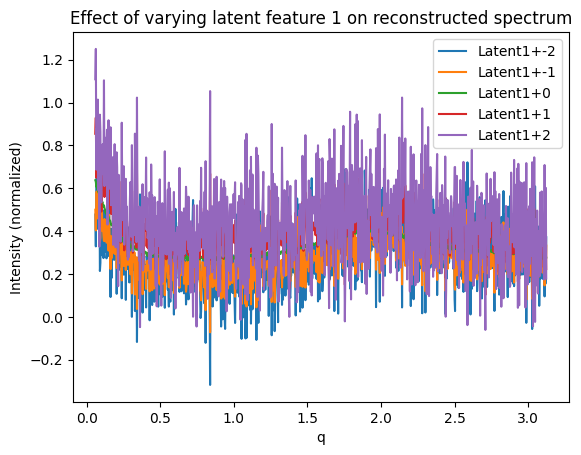

In [11]:
import numpy as np
# Pick a sample's latent encoding
sample_idx = 0
latent_vec = latent_features[sample_idx].copy()

# Vary the first latent dimension over a range
for delta in [-2, -1, 0, 1, 2]:
    new_latent = latent_vec.copy()
    new_latent[0] += delta  # tweak first latent feature
    new_latent_tensor = torch.tensor(new_latent, dtype=torch.float32)
    # Detach before converting to NumPy
    recon_spectrum = autoencoder.decoder(new_latent_tensor).detach().numpy()
    plt.plot(q_vals, recon_spectrum, label=f"Latent1+{delta}")

plt.title("Effect of varying latent feature 1 on reconstructed spectrum")
plt.xlabel("q")
plt.ylabel("Intensity (normalized)")
plt.legend()
plt.show()
